In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#df = pd.read_csv("data/metrics_results_without_100000.csv")
df = pd.read_csv("data/metrics_results.csv")

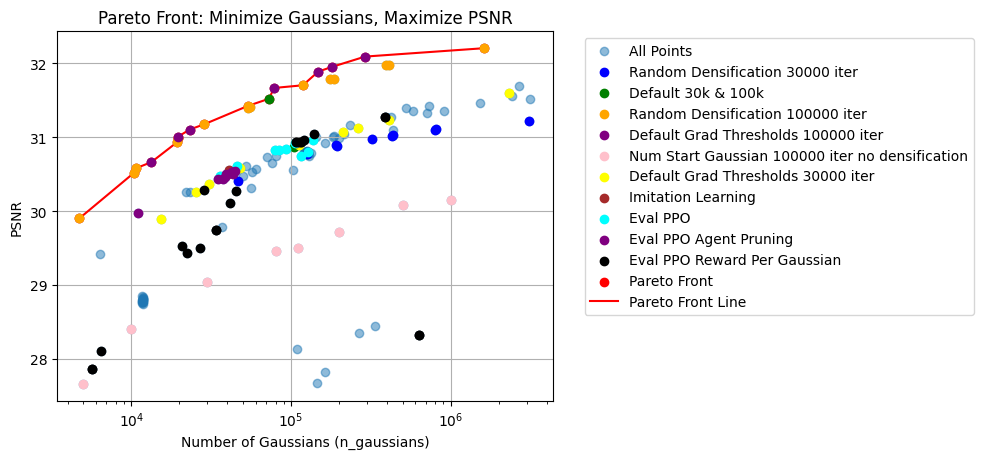

In [7]:
import pandas as pd
from collections import defaultdict
from paretoset import paretoset
import matplotlib.pyplot as plt

# Extract unique run_ids
unique_run_ids = df['run_id']

# Step 2: Define the mapping of run ID categories
run_categories = {
    'random': {'label': 'Random Densification 30000 iter', 'color': 'blue'},
    'rand_100000_iterations_iterations': {'label': 'Random Densification 100000 iter', 'color': 'orange'},
    'default': {'label': 'Default 30k & 100k', 'color': 'green'},
    'grad_thresholds_131': {'label': 'Default Grad Thresholds 100000 iter', 'color': 'purple'},
    #'ppo_relative_diff_psnr': {'label': 'PPO Relative Diff PSNR 30000 iter', 'color': 'grey'},
    'num_start_gaussian_100000': {'label': 'Num Start Gaussian 100000 iter no densification', 'color': 'pink'},
    'grad_thresholds_30000': {'label': 'Default Grad Thresholds 30000 iter', 'color': 'yellow'},
    #'per_gaussian_reward_8h_001_004': {'label': 'Per Gaussian Reward', 'color': 'black'},
    'imitation_learning': {'label': 'Imitation Learning', 'color': 'brown'},
    #'eval_grad_not_norm_ppo': {'label': 'Eval Grad Not Norm PPO', 'color': 'red'},
    "eval_ppo_imitation": {'label': 'Eval PPO', 'color': 'cyan'},
    "eval_ppo_agent_pruning_imitation": {'label': 'Eval PPO Agent Pruning', 'color': 'purple'},
    "eval_ppo_reward_per_gaussian_imitation": {'label': 'Eval PPO Reward Per Gaussian', 'color': 'black'},
}

# Step 3: Automatically categorize the run IDs based on the keywords in the run ID
categorized_runs = defaultdict(list)

for run_id in unique_run_ids:
    for keyword in run_categories:
        if keyword in run_id:
            categorized_runs[keyword].append(run_id)

# Step 4: Use the paretoset package to compute the Pareto front (maximize PSNR, minimize n_gaussians)
mask = paretoset(df[['psnr', 'n_gaussians']], sense=['max', 'min'])

# Extract the Pareto front from the results
pareto_df = df[mask]

# Step 4.1: Sort the Pareto front by n_gaussians
pareto_df = pareto_df.sort_values(by='n_gaussians')

# Step 5: Plot all points first in a default style (e.g., grey color)
plt.scatter(df['n_gaussians'], df['psnr'], label='All Points', alpha=0.5)#, color='grey')

# Step 6: Plot each category of runs with their respective label and color
for keyword, run_list in categorized_runs.items():
    label = run_categories[keyword]['label']
    color = run_categories[keyword]['color']
    for run_id in run_list:
        highlight_data = df[df['run_id'].str.contains(run_id)]
        plt.scatter(highlight_data['n_gaussians'], highlight_data['psnr'], color=color, label=label, zorder=3)

# Step 7: Plot the Pareto front and connect the points with a line
plt.scatter(pareto_df['n_gaussians'], pareto_df['psnr'], color='red', label='Pareto Front', zorder=2)
plt.plot(pareto_df['n_gaussians'], pareto_df['psnr'], color='red', linestyle='-', label='Pareto Front Line')

# Customize the plot
plt.title('Pareto Front: Minimize Gaussians, Maximize PSNR')
plt.xscale('log')
plt.xlabel('Number of Gaussians (n_gaussians)')
plt.ylabel('PSNR')

# Show only one legend entry for each category
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.show()


In [8]:
import plotly.graph_objects as go
from paretoset import paretoset
import numpy as np

# Step 1: Compute the Pareto front using the paretoset package
mask = paretoset(df[['psnr', 'n_gaussians']], sense=['max', 'min'])

# Extract the Pareto front from the results
pareto_df = df[mask]

# Step 2: Sort the Pareto front by n_gaussians (or psnr if you prefer)
pareto_df = pareto_df.sort_values(by='n_gaussians')

# Step 3: Plot all points
fig = go.Figure()

# Add all points to the scatter plot (optional if you want a background of all points)
fig.add_trace(go.Scatter(
    x=df['n_gaussians'],
    y=df['psnr'],
    mode='markers',
    marker=dict(size=6, color='gray', opacity=0.5),
    text=df['run_id'],  # Run ID will show when hovering
    hoverinfo='text',
    name='All Points'
))

# Track whether the random and default categories have been added to the legend
random_legend_added = False
default_legend_added = False

# Highlight "random" runs in blue
for run_id in highlight_runs:
    if 'random' in run_id:
        highlight_data = df[df['run_id'].str.contains(run_id)]
        fig.add_trace(go.Scatter(
            x=highlight_data['n_gaussians'],
            y=highlight_data['psnr'],
            mode='markers',
            marker=dict(size=8, color='blue'),
            text=highlight_data['run_id'],  # Run ID will show when hovering
            hoverinfo='text',
            name='Random Runs' if not random_legend_added else None,  # Show legend label only once
            legendgroup='random',  # Group random runs under one legend group
            showlegend=not random_legend_added  # Only show legend for the first run
        ))
        random_legend_added = True  # Mark random legend as added

# Highlight "default" runs in green
for run_id in highlight_runs:
    if 'default' in run_id:
        highlight_data = df[df['run_id'].str.contains(run_id)]
        fig.add_trace(go.Scatter(
            x=highlight_data['n_gaussians'],
            y=highlight_data['psnr'],
            mode='markers',
            marker=dict(size=8, color='green'),
            text=highlight_data['run_id'],  # Run ID will show when hovering
            hoverinfo='text',
            name='Default Runs' if not default_legend_added else None,  # Show legend label only once
            legendgroup='default',  # Group default runs under one legend group
            showlegend=not default_legend_added  # Only show legend for the first run
        ))
        default_legend_added = True  # Mark default legend as added

# Add Pareto front points
fig.add_trace(go.Scatter(
    x=pareto_df['n_gaussians'],
    y=pareto_df['psnr'],
    mode='markers+lines',
    marker=dict(size=8, color='red'),
    line=dict(color='red', width=2),
    text=pareto_df['run_id'],  # Run ID will show when hovering
    hoverinfo='text',
    name='Pareto Front'
))

# Step 4: Update layout
fig.update_layout(
    title='Pareto Front: Minimize Gaussians, Maximize PSNR',
    xaxis=dict(title='Number of Gaussians (n_gaussians)', type='log'),
    yaxis=dict(title='PSNR'),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    hovermode='closest'
)

# Step 5: Show the interactive plot
fig.show()


NameError: name 'highlight_runs' is not defined

In [68]:
import plotly.graph_objects as go
from paretoset import paretoset
import numpy as np

# Step 1: Compute the Pareto front using the paretoset package
mask = paretoset(df_results[['psnr', 'n_gaussians']], sense=['max', 'min'])

# Extract the Pareto front from the results
pareto_df = df_results[mask]

# Step 2: Sort the Pareto front by n_gaussians (or psnr if you prefer)
pareto_df = pareto_df.sort_values(by='n_gaussians')

# Step 3: Plot all points
fig = go.Figure()

# Add all points to the scatter plot
fig.add_trace(go.Scatter(
    x=df_results['n_gaussians'],
    y=df_results['psnr'],
    mode='markers',
    marker=dict(size=6, color='blue', opacity=0.5),
    text=df_results['run_id'],  # Run ID will show when hovering
    hoverinfo='text',
    name='All Points'
))

# Highlight specific runs
colors = np.random.rand(len(highlight_runs), 3)  # Generate random colors for each highlighted run

for i, run_id in enumerate(highlight_runs):
    highlight_data = df_results[df_results['run_id'].str.contains(run_id)]
    fig.add_trace(go.Scatter(
        x=highlight_data['n_gaussians'],
        y=highlight_data['psnr'],
        mode='markers',
        marker=dict(size=8, color=f'rgb({colors[i][0]*255},{colors[i][1]*255},{colors[i][2]*255})'),
        text=highlight_data['run_id'],  # Run ID will show when hovering
        hoverinfo='text',
        name=f'{run_id}'
    ))

# Add Pareto front points
fig.add_trace(go.Scatter(
    x=pareto_df['n_gaussians'],
    y=pareto_df['psnr'],
    mode='markers+lines',
    marker=dict(size=8, color='red'),
    line=dict(color='red', width=2),
    text=pareto_df['run_id'],  # Run ID will show when hovering
    hoverinfo='text',
    name='Pareto Front'
))

# Step 4: Update layout
fig.update_layout(
    title='Pareto Front: Minimize Gaussians, Maximize PSNR',
    xaxis=dict(title='Number of Gaussians (n_gaussians)', type='log'),
    yaxis=dict(title='PSNR'),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    hovermode='closest')

# Step 5: Show the interactive plot
fig.show()
